Columns in the DataFrame: Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')


<ipython-input-1-653a80051799>:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='flight_number', y='launchpad', data=df, palette='Set2')


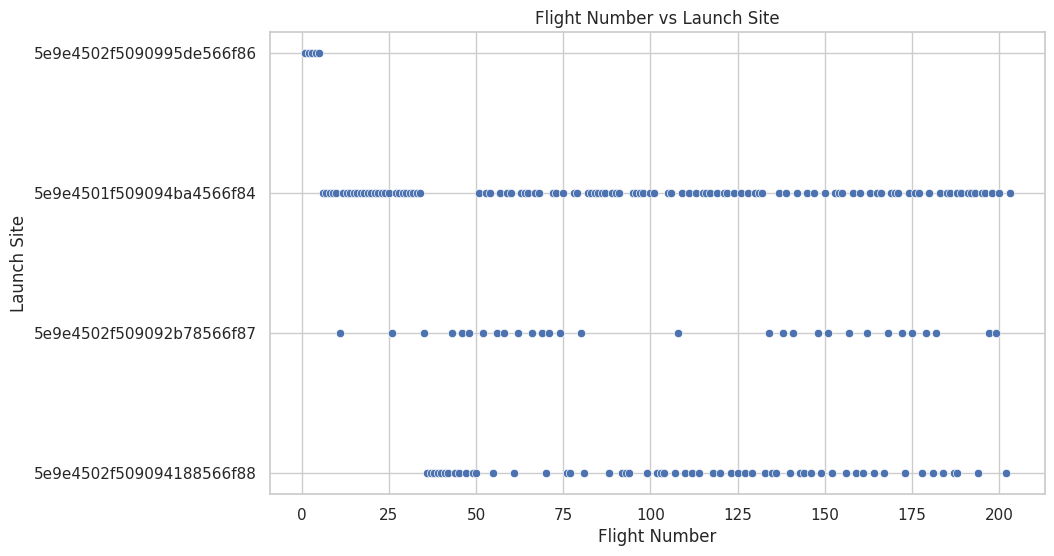

<ipython-input-1-653a80051799>:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='payload_mass', y='launchpad', data=df, palette='Set2')


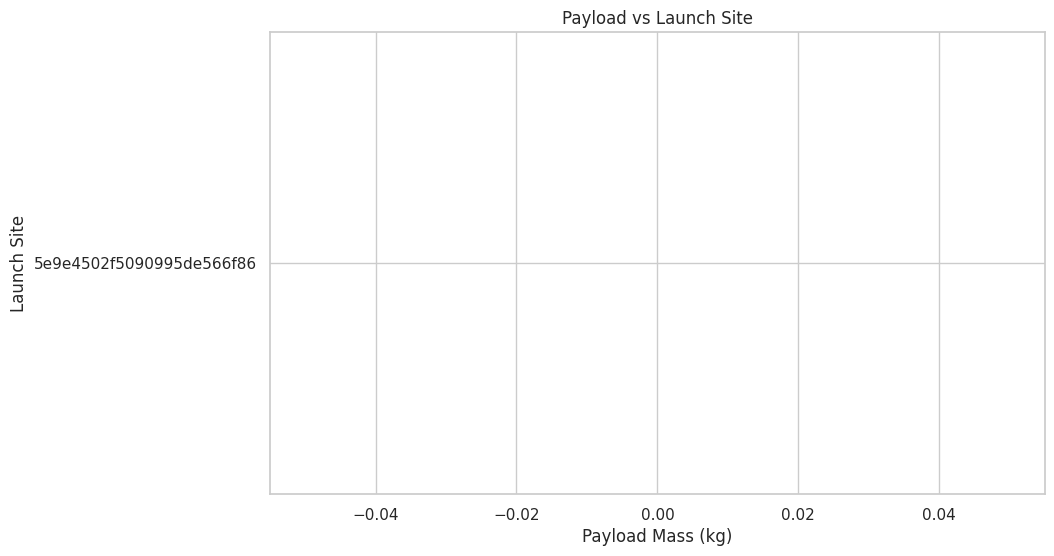

'orbit' column not found. Please check the available columns.
'orbit' column not found. Please check the available columns.
'orbit' column not found. Please check the available columns.


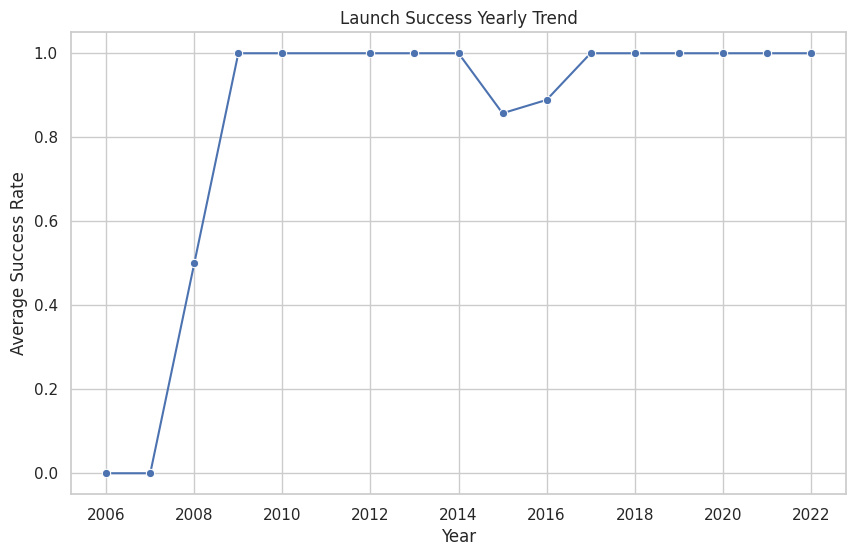

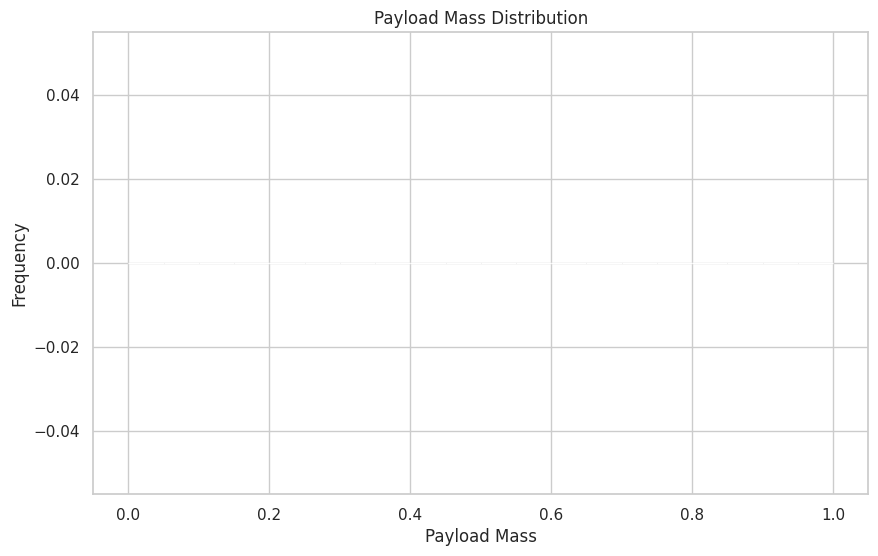

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch data from SpaceX API
url = "https://api.spacexdata.com/v4/launches"
response = requests.get(url)
data = response.json()

# Convert JSON data to DataFrame
df = pd.json_normalize(data)

# Print column names to inspect them
print("Columns in the DataFrame:", df.columns)

# Data Cleaning: Remove rows with missing data in relevant columns
df.dropna(subset=['payloads', 'launchpad'], inplace=True)

# Extract payload mass from 'payloads'
# Check if payload is a list and if the list contains a dictionary with 'mass_kg' field
df['payload_mass'] = df['payloads'].apply(lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and 'mass_kg' in x[0] else None)

# Set up the plot style
sns.set(style="whitegrid")

# Scatter Plot 1: Flight Number vs Launch Site
plt.figure(figsize=(10, 6))
sns.scatterplot(x='flight_number', y='launchpad', data=df, palette='Set2')
plt.title('Flight Number vs Launch Site')
plt.xlabel('Flight Number')
plt.ylabel('Launch Site')
plt.show()

# Scatter Plot 2: Payload vs Launch Site
plt.figure(figsize=(10, 6))
sns.scatterplot(x='payload_mass', y='launchpad', data=df, palette='Set2')
plt.title('Payload vs Launch Site')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Launch Site')
plt.show()

# Scatter Plot 3: Flight Number vs Orbit Type
# Check if the 'orbit' column exists, or change it to another relevant column.
if 'orbit' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='flight_number', y='orbit', data=df, palette='Set2')
    plt.title('Flight Number vs Orbit Type')
    plt.xlabel('Flight Number')
    plt.ylabel('Orbit Type')
    plt.show()
else:
    print("'orbit' column not found. Please check the available columns.")

# Scatter Plot 4: Payload vs Orbit Type
# Again, check for the correct column name for orbit (if available)
if 'orbit' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass', y='orbit', data=df, palette='Set2')
    plt.title('Payload vs Orbit Type')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Orbit Type')
    plt.show()
else:
    print("'orbit' column not found. Please check the available columns.")

# Bar Chart 1: Success Rate vs Orbit Type
# You might want to change 'orbit' to another relevant field if necessary
if 'orbit' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='orbit', y='success', data=df, ci=None, palette='Set2')
    plt.title('Success Rate vs Orbit Type')
    plt.xlabel('Orbit Type')
    plt.ylabel('Success Rate')
    plt.show()
else:
    print("'orbit' column not found. Please check the available columns.")

# Line Chart: Launch Success Yearly Trend
df['date_utc'] = pd.to_datetime(df['date_utc'])
df['year'] = df['date_utc'].dt.year
yearly_success = df.groupby('year')['success'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='success', data=yearly_success, marker='o', color='b')
plt.title('Launch Success Yearly Trend')
plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.show()

# Histogram: Payload Mass Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['payload_mass'], kde=True, color='green', bins=20)
plt.title('Payload Mass Distribution')
plt.xlabel('Payload Mass')
plt.ylabel('Frequency')
plt.show()


In [2]:
import folium
from folium import plugins

# Create a base map centered on a specific location (e.g., SpaceX's headquarters)
map = folium.Map(location=[28.5721, -80.6480], zoom_start=6)

# Add markers for launch sites
launch_sites = {
    'Cape Canaveral': [28.3922, -80.6077],
    'Kennedy Space Center': [28.5721, -80.6480],
    'Vandenberg Space Force Base': [34.7325, -120.6108],
    'Space Launch Complex 40': [28.3922, -80.6077]
}

# Add markers to the map
for site, coord in launch_sites.items():
    folium.Marker(location=coord, popup=site).add_to(map)

# Add circles to represent areas of influence around each launch site (for proximity analysis)
for site, coord in launch_sites.items():
    folium.Circle(
        location=coord,
        radius=5000,  # Radius in meters
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2,
        popup=f'Proximity to {site}'
    ).add_to(map)

# Add lines between different sites to show possible connections or flight paths
folium.PolyLine(
    locations=[launch_sites['Cape Canaveral'], launch_sites['Kennedy Space Center']],
    color='red',
    weight=2.5,
    opacity=1
).add_to(map)

# Adjust the map view to fit all markers (using fit_bounds)
map.fit_bounds([coord for coord in launch_sites.values()])

# Save the map to an HTML file
map.save('interactive_folium_map.html')

# Display the map inline (for Jupyter notebooks)
map


In [3]:
!pip install dash
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd

# Sample DataFrame (replace with your actual data)
data = {
    'Launch Site': ['CCAFS LC-40', 'CCAFS SLC-40', 'KSC LC-39A', 'VAFB SLC-4E'],
    'Success Rate': [0.95, 0.89, 0.98, 0.85],
    'Payload Mass': [5000, 4000, 6000, 4500],
    'Orbit': ['LEO', 'GTO', 'LEO', 'LEO']
}
df = pd.DataFrame(data)

# Initialize the Dash app
app = dash.Dash(__name__)

# Create pie chart for Launch Site Success Rate
pie_chart = px.pie(df, names='Launch Site', values='Success Rate', title='Launch Site Success Rate')

# Create scatter plot for Payload Mass vs. Launch Site
scatter_plot = px.scatter(df, x='Launch Site', y='Payload Mass', color='Orbit', title='Payload Mass vs Launch Site')

# Layout of the dashboard
app.layout = html.Div(children=[
    html.H1("SpaceX Launch Dashboard", style={'textAlign': 'center'}),

    html.Div(children=[
        html.Div(children=[
            html.H3("Launch Site Success Rate"),
            dcc.Graph(figure=pie_chart)
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div(children=[
            html.H3("Payload Mass vs Launch Site"),
            dcc.Graph(figure=scatter_plot)
        ], style={'width': '48%', 'display': 'inline-block'})
    ], style={'display': 'flex', 'justify-content': 'space-between'}),

    html.Div(children=[
        html.H3("Interactive Payload Mass Filter"),
        dcc.RangeSlider(
            id='payload-slider',
            min=1000,
            max=7000,
            step=500,
            marks={i: f'{i}kg' for i in range(1000, 7001, 1000)},
            value=[1000, 7000],
            tooltip={'placement': 'bottom', 'always_visible': True}
        ),
        html.Div(id='slider-output-container')
    ], style={'paddingTop': '20px'})
])

# Define interactivity for the range slider
@app.callback(
    dash.dependencies.Output('slider-output-container', 'children'),
    [dash.dependencies.Input('payload-slider', 'value')]
)
def update_output(value):
    return f"Selected Payload Range: {value[0]}kg - {value[1]}kg"

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


<ipython-input-3-caf82e1c9afc>:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-caf82e1c9afc>:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>